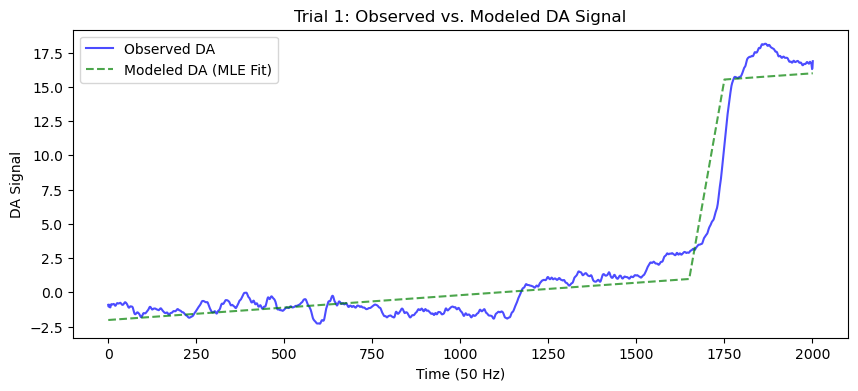

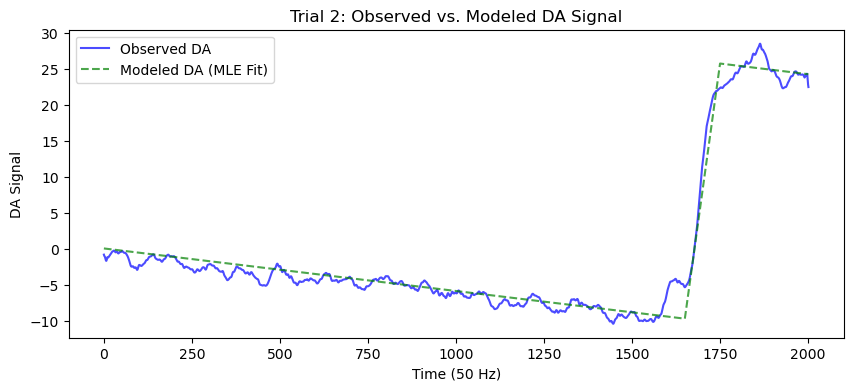

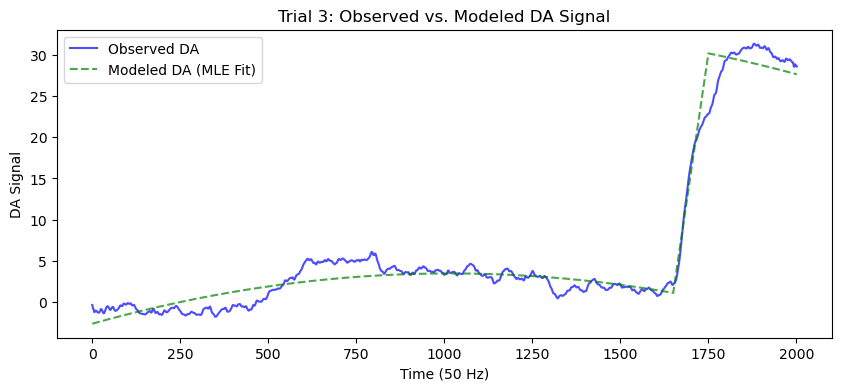

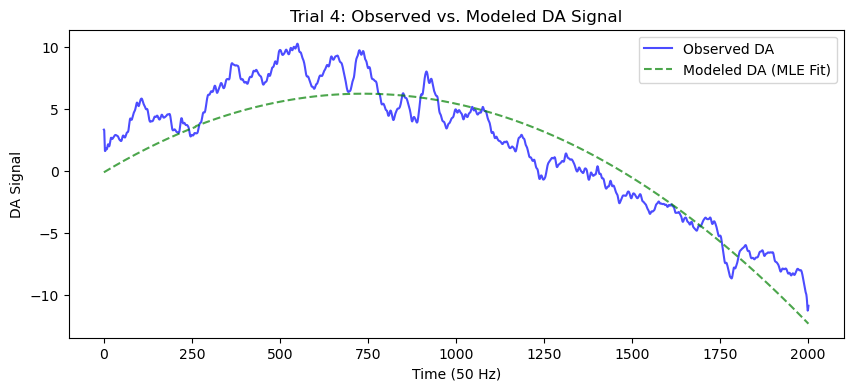

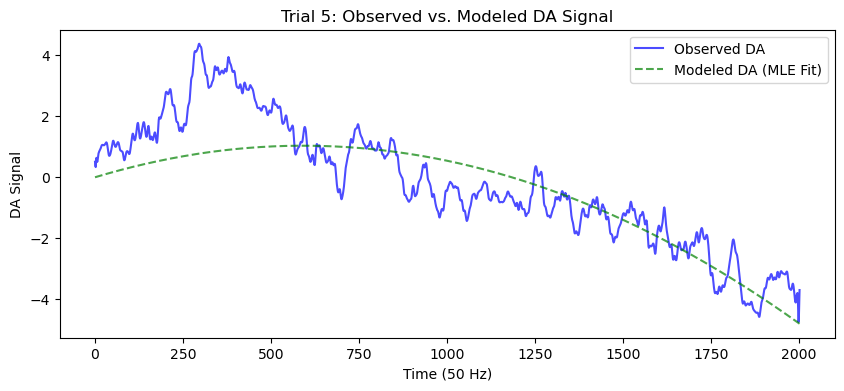

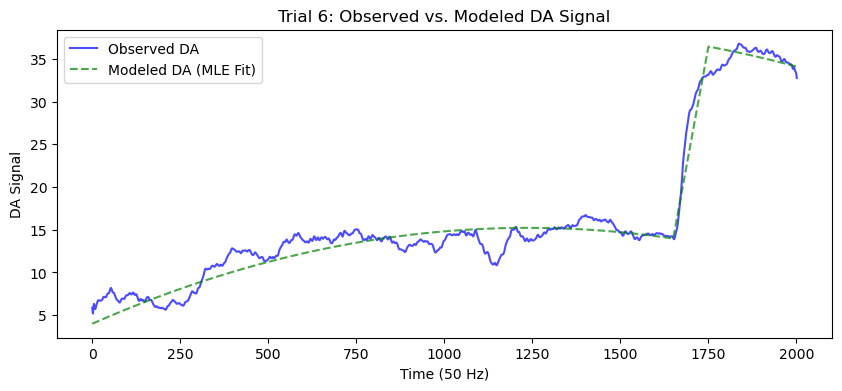

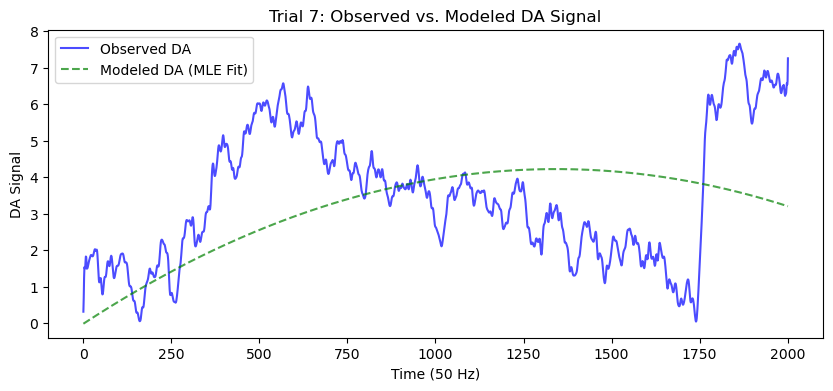

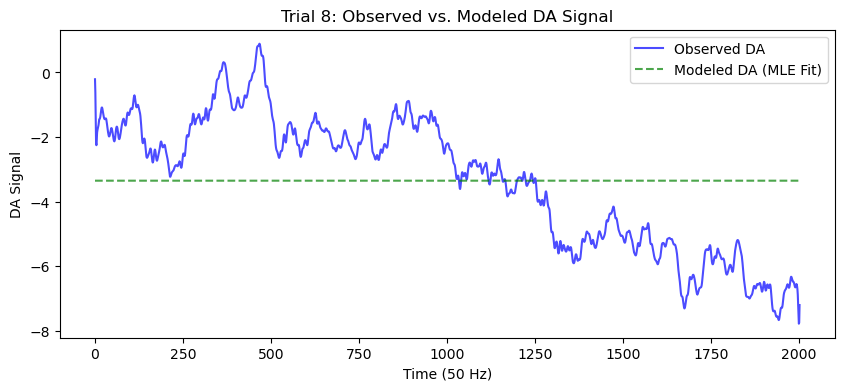

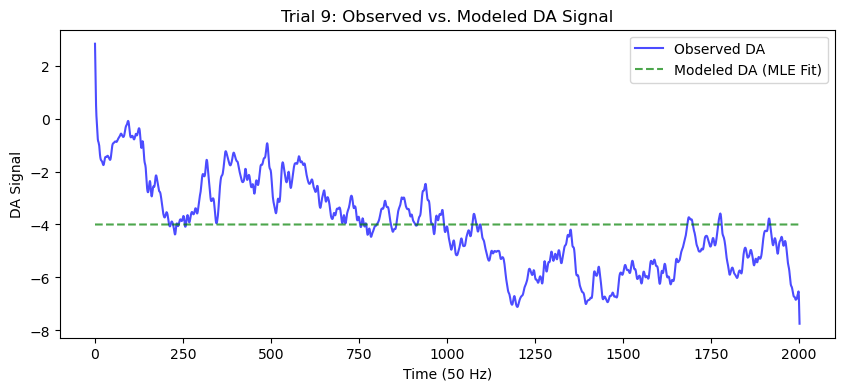

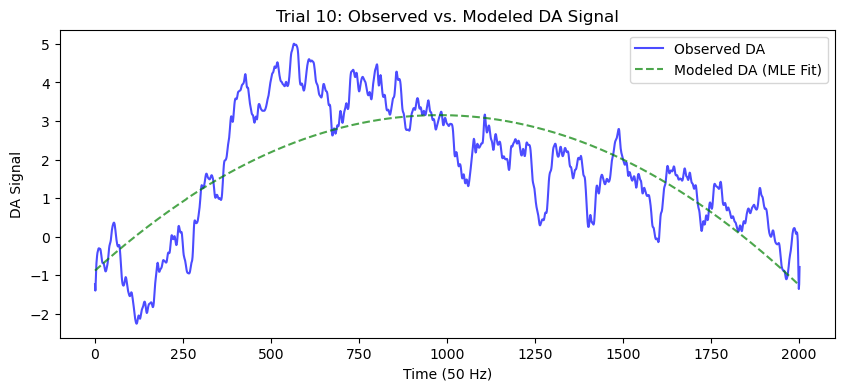

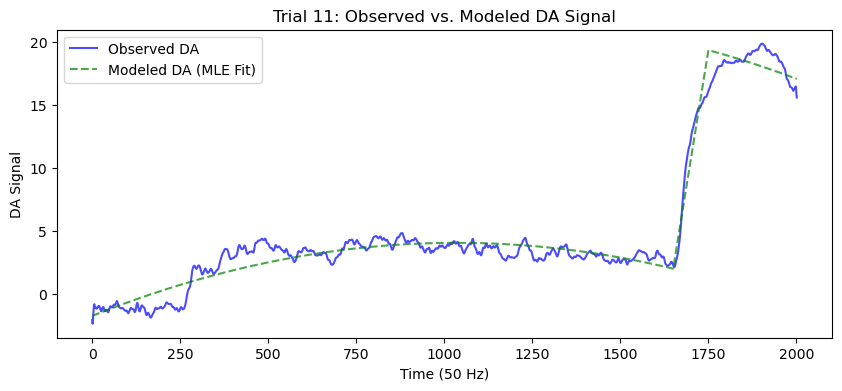

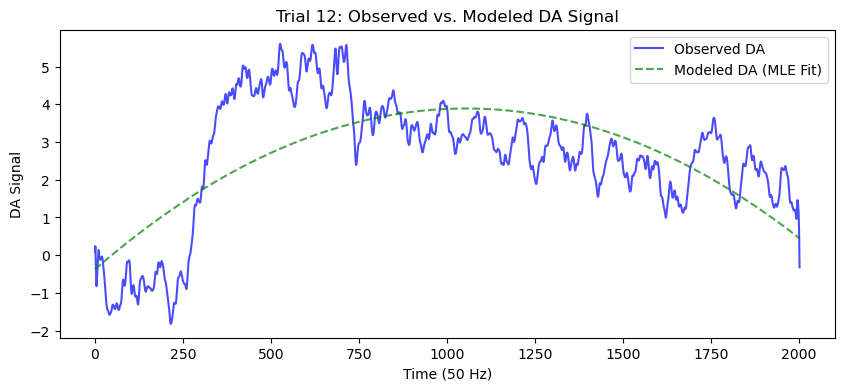

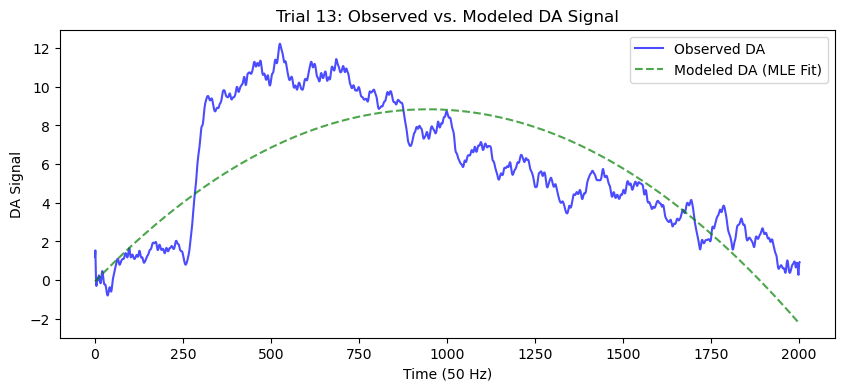

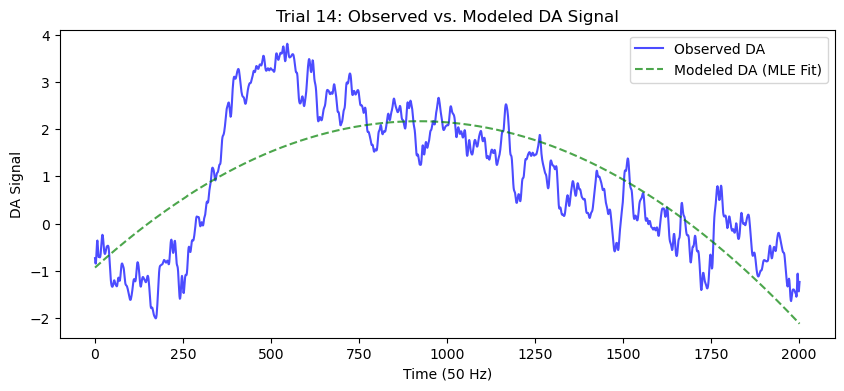

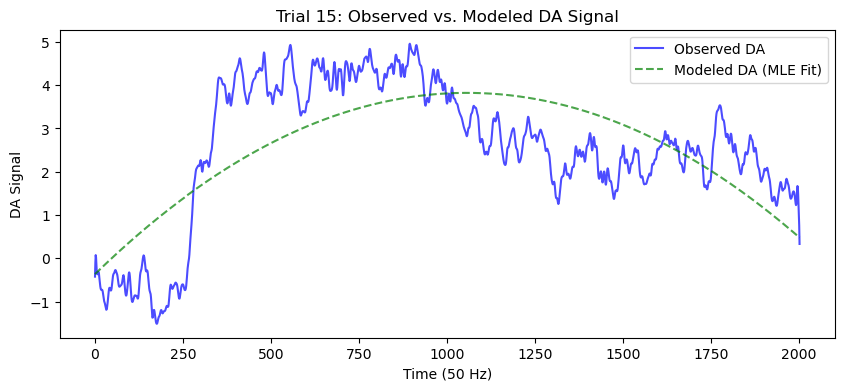

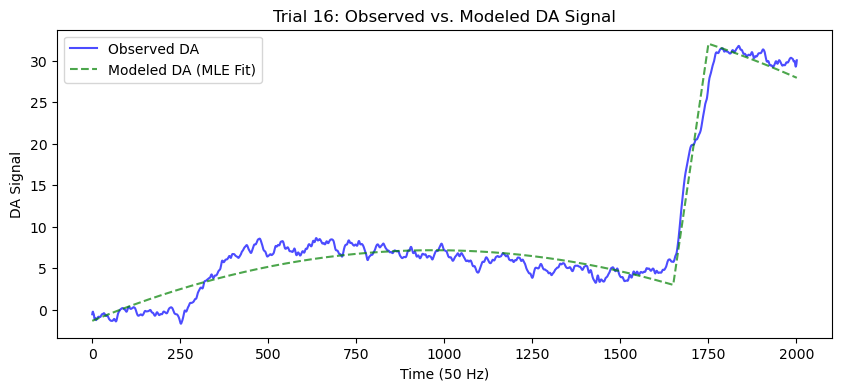

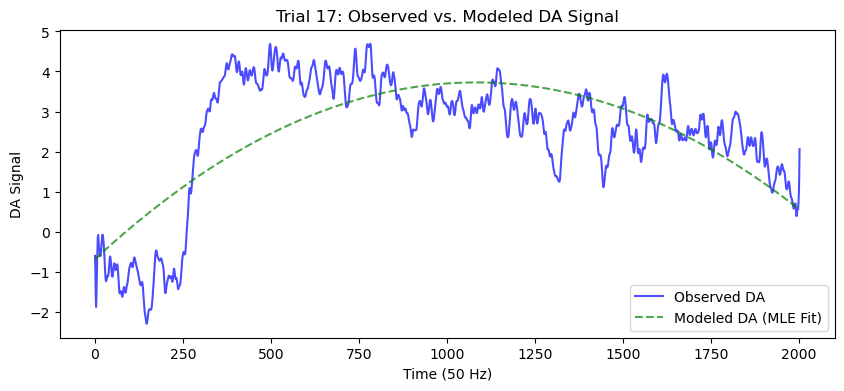

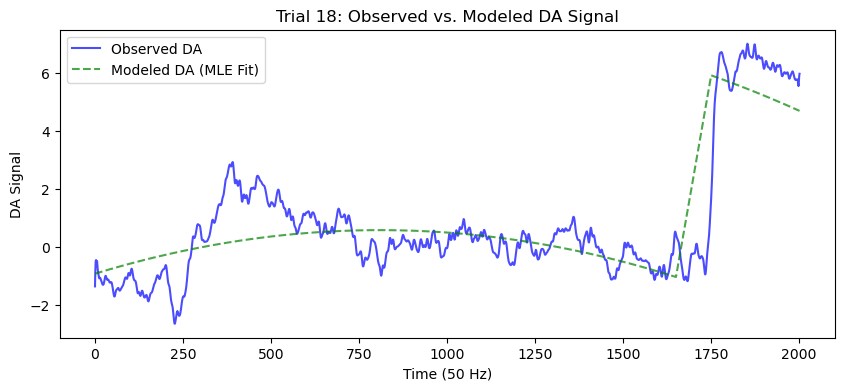

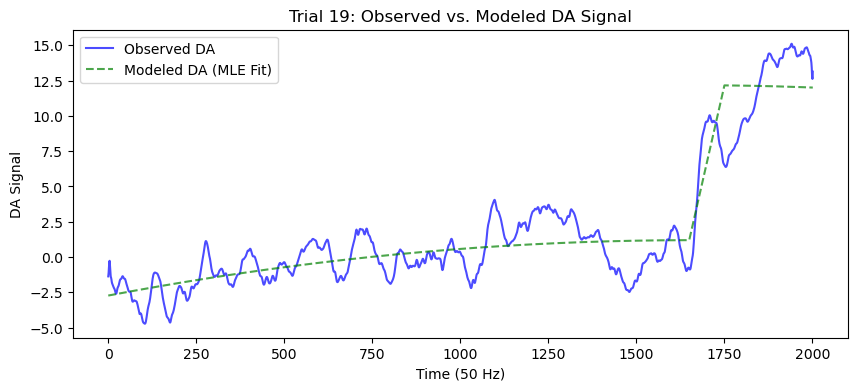

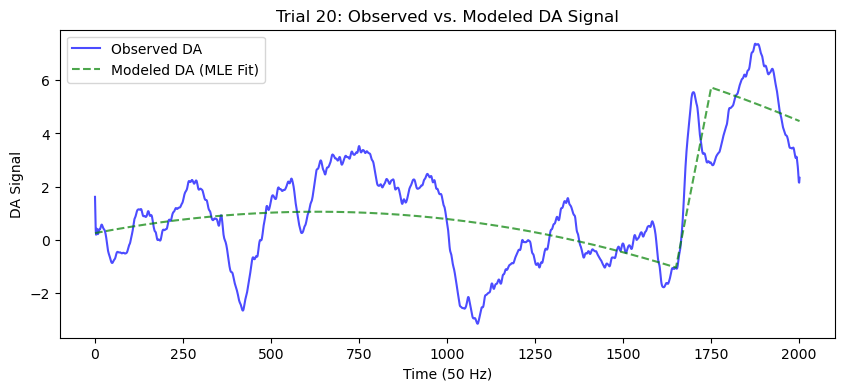

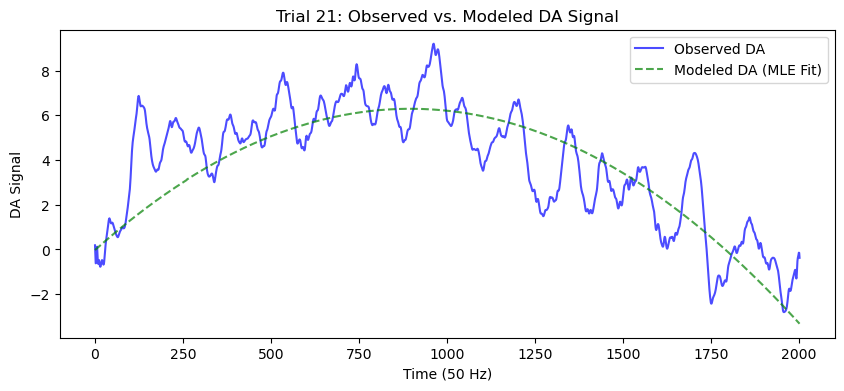

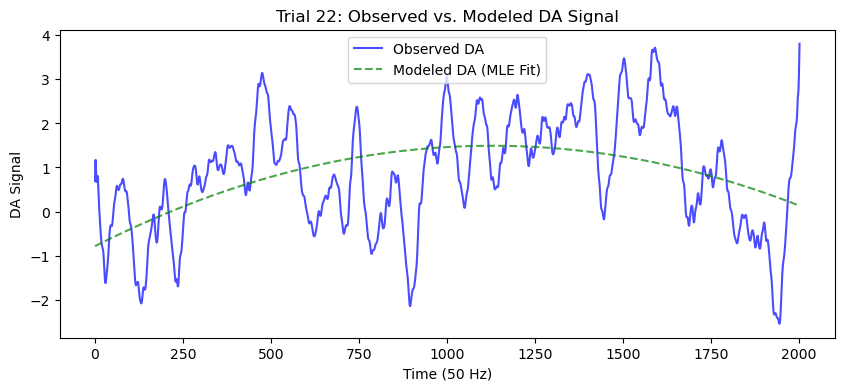

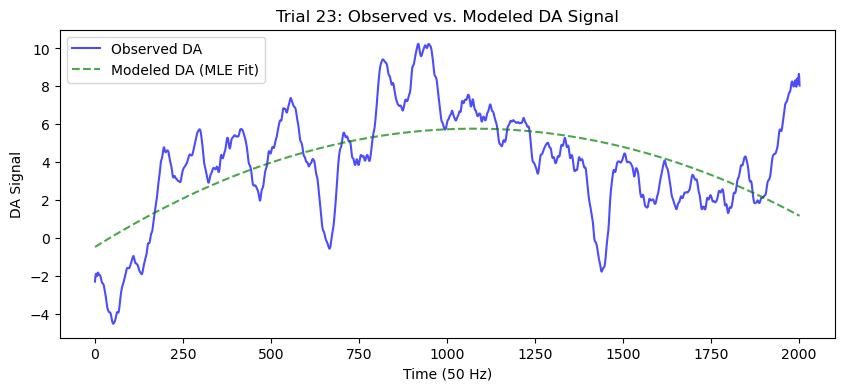

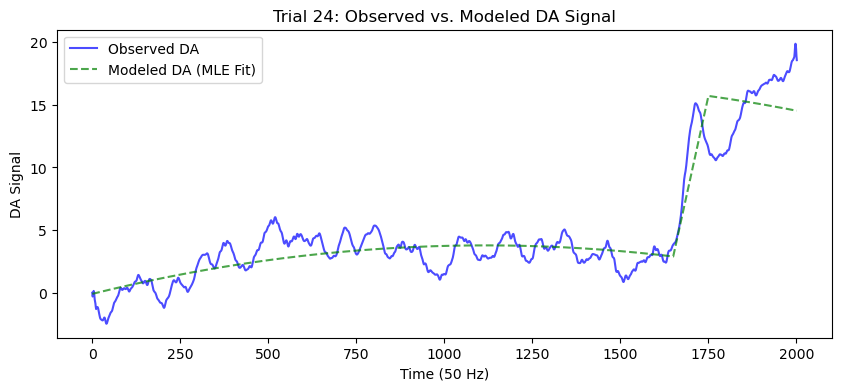

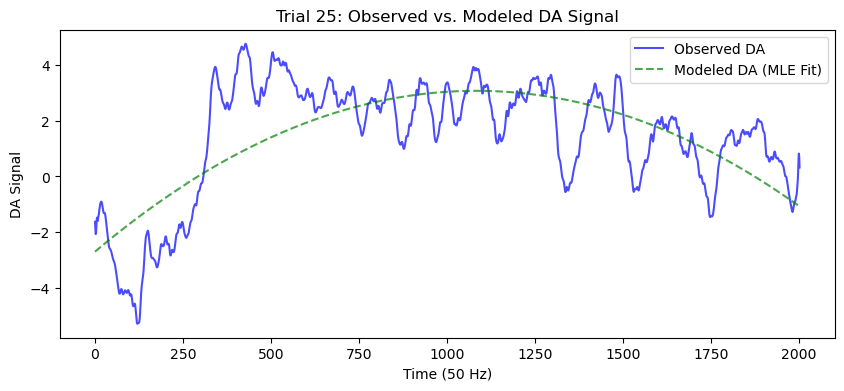

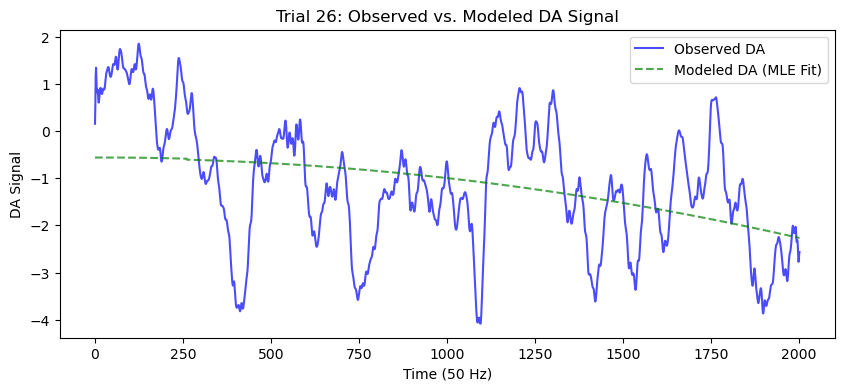

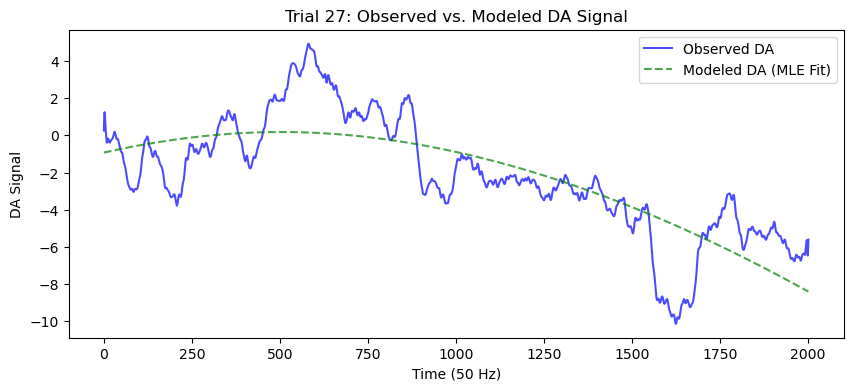

Overall MSE across all trials: 2.4039758433656
Optimized Parameters for Each Trial:
    Base Alpha     Gamma  Uncertainty (a)  Baseline (b)  Beta (Dynamic α)  \
0     0.430307  0.993775         0.000000     -2.022134      8.868595e-03   
1     0.070128  0.500000         0.000000      0.031191      5.781534e-02   
2     0.421779  0.998943         0.037309     -2.665679      3.136070e-03   
3     0.955111  0.500000         0.000142     -0.104025      1.100695e-01   
4     0.117716  0.500000         0.000016     -0.009147      3.022532e-01   
5     0.093066  0.999223         0.081538      4.000000      0.000000e+00   
6     0.252770  0.500000         0.000007     -0.009975      1.835900e-03   
7     0.010000  1.000000         0.000000     -3.353857      0.000000e+00   
8     0.010000  1.000000         0.000000     -4.000000      0.000000e+00   
9     0.024003  0.902094         0.000907     -0.877173      8.661917e-07   
10    0.190441  0.999006         0.060296     -1.759196      2.149293

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load data
fiber_data = pd.read_csv("./data/PMA/DP066_PMA_allTrials.csv", header=None)
corrected_shock_outcomes = pd.read_csv("./data/PMA/dp066_shock_outcomes.csv", header=None).values.flatten()
num_trials = fiber_data.shape[0]
num_time_steps = fiber_data.shape[1]
shock_start, shock_end, tone_onset = 1650, 1750, 260

# Define the TD model
def td_model(trial_data, s_t_vector, params, trial_outcome):
    base_alpha, gamma, a, b, beta, lambda_tone, lambda_shock, lambda_omission, lambda_tone_onset = params
    num_time_steps = len(trial_data)

    # Initialize arrays
    da_signal_trial = np.zeros(num_time_steps)
    value_function_trial = np.zeros(num_time_steps)
    td_error_trial = np.zeros(num_time_steps)

    # Initialize DA signal with the baseline
    da_signal_trial[0] = b

    # Compute TD error and DA signal for each time step
    for t in range(num_time_steps - 1):
        # Value function
        value_function_trial[t] = a * t + b

        # Salience weight
        salience_weight = (
            lambda_tone +
            lambda_shock * (trial_outcome == 1) +
            lambda_omission * (trial_outcome == 0) +
            (lambda_tone_onset if t == tone_onset else 0)
        )

        # Temporal Difference Error
        v_next = a * (t + 1) + b if t + 1 < num_time_steps else 0
        td_error_trial[t] = salience_weight * (s_t_vector[t] + gamma * v_next - value_function_trial[t])

        # Dynamic learning rate
        dynamic_alpha = base_alpha * (1 + beta * np.exp(-abs(td_error_trial[t])))

        # Update DA signal
        da_signal_trial[t + 1] = da_signal_trial[t] + dynamic_alpha * td_error_trial[t]

    return da_signal_trial

# Define the Negative Log-Likelihood (SSE)
def negative_log_likelihood(params, trial_index):
    # Observed signal for the trial
    observed_signal = fiber_data.values[trial_index, :]

    # Create stimulus vector
    s_t_vector = np.zeros(num_time_steps)
    if corrected_shock_outcomes[trial_index] == 1:
        s_t_vector[shock_start:shock_end] = 1  # Shock trials

    # Modeled signal
    modeled_signal = td_model(observed_signal, s_t_vector, params, corrected_shock_outcomes[trial_index])

    # Compute SSE (negative log-likelihood)
    sse = np.sum((observed_signal - modeled_signal) ** 2)
    return sse  # Minimize this

# Optimize parameters for each trial
def optimize_mle_for_trial(trial_index):
    # Initial parameter guesses
    initial_params = [0.1, 0.9, 0.05, 0.5, 0.1, 0.2, 0.8, -0.8, 0.9]
    bounds = [
        (0.01, 1), (0.5, 1), (0, 0.1), (-4, 4), (0, 1),
        (0, 5), (-2, 2), (-2, 0), (0, 5)
    ]

    # Minimize the negative log-likelihood (SSE)
    result = minimize(negative_log_likelihood, initial_params, args=(trial_index,), bounds=bounds, method="L-BFGS-B")
    optimized_params = result.x
    return optimized_params, result.fun  # Return params and SSE

# Sequential optimization and plotting
optimized_results = []
observed_signals = []  # Store all observed signals
modeled_signals = []  # Store all modeled signals

for trial_index in range(num_trials):
    # Optimize model for the current trial
    params, sse = optimize_mle_for_trial(trial_index)
    optimized_results.append((trial_index, params, sse))

    # Extract observed and modeled signals for plotting
    observed_signal = fiber_data.values[trial_index, :]
    s_t_vector = np.zeros(num_time_steps)
    if corrected_shock_outcomes[trial_index] == 1:
        s_t_vector[shock_start:shock_end] = 1
    modeled_signal = td_model(observed_signal, s_t_vector, params, corrected_shock_outcomes[trial_index])

    # Store signals for overall MSE calculation
    observed_signals.append(observed_signal)
    modeled_signals.append(modeled_signal)

    # Plot observed vs. modeled DA signal for the trial
    plt.figure(figsize=(10, 4))
    plt.plot(observed_signal, label="Observed DA", color="blue", alpha=0.7)
    plt.plot(modeled_signal, label="Modeled DA (MLE Fit)", color="green", linestyle="--", alpha=0.7)
    plt.title(f"Trial {trial_index + 1}: Observed vs. Modeled DA Signal")
    plt.xlabel("Time (50 Hz)")
    plt.ylabel("DA Signal")
    plt.legend()
    plt.show()

# Calculate overall MSE across all trials
def calculate_overall_mse(observed_signals, modeled_signals):
    total_mse = 0
    for obs, mod in zip(observed_signals, modeled_signals):
        total_mse += np.mean((obs - mod) ** 2)
    overall_mse = total_mse / len(observed_signals)  # Average MSE across all trials
    return overall_mse

# Compute and display the overall MSE
overall_mse = calculate_overall_mse(observed_signals, modeled_signals)
print(f"Overall MSE across all trials: {overall_mse}")

# Extract parameters into a DataFrame
optimized_parameters_df = pd.DataFrame(
    [res[1] for res in optimized_results],
    columns=[
        "Base Alpha", "Gamma", "Uncertainty (a)", "Baseline (b)", "Beta (Dynamic α)",
        "λ_tone", "λ_shock", "λ_omission", "λ_tone_onset"
    ]
)
optimized_parameters_df["Trial"] = np.arange(1, num_trials + 1)

# Display the DataFrame for parameter results
print("Optimized Parameters for Each Trial:")
print(optimized_parameters_df)

# Optional: Save results to a CSV
do_save = False
if do_save:
    optimized_parameters_df.to_csv("optimized_parameters_mle.csv", index=False)
